### Importations

In [1]:
import os
import numpy as np
import xarray as xr
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List, Tuple, TypeAlias
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
plt.rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

data disponible at
https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file

# Run forward *Tunax* LES simulations

In [2]:
from tunax import Obs, SingleColumnModel
from tunax.closures import KepsParameters
import jax.numpy as jnp
from jax import vmap
import equinox as eqx
import numpy as np
import os

timeframe_list = [6, 12, 24, 48, 72]
space_step_list = [1, 2, 4]
forcing_list = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]

var_names = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

dims = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

In [3]:
from dataclasses import replace
for space_step in space_step_list[:1]:
    for timeframe in timeframe_list[:1]:
        for forcing in forcing_list:
            print(f'{space_step}m', f'{timeframe}h', forcing)
            filename = os.path.join(
                'Wagner_LES',f'{timeframe}h',
                f'{space_step}m', f'{forcing}.jld2')
            output_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
            obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)

            # case corrections
            obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
            # new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
            # obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)
            obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, (0., -obs.metadatas['b_str']), is_leaf=lambda x: x is None)
            obs: Obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

            # passive tracer forcing
            omega_p = 1/obs.metadatas['pt_timescale']
            lambda_c = obs.metadatas['pt_width']
            zc = obs.metadatas['pt_depth']
            l_z = obs.trajectory.grid.hbot
            wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
            # new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
            # new_case = replace(new_case, pt_forcing_type='constant')
            # obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing, obs, wrapped_forcing_pt, is_leaf=lambda x: x is None)
            obs: Obs = eqx.tree_at(lambda t: t.case.pt_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

            # sunny forcing
            if forcing == 'strong_wind_and_sunny':
                jb = obs.metadatas['sunny_flux']
                eps1 = 0.6
                lambda1 = 1.
                lambda2 = 16.
                b_str = obs.case.b_forcing[1]
                wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                # new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
                # new_case = replace(new_case, b_forcing_type='constant')
                # obs: Obs = eqx.tree_at(lambda t: t.case, obs, new_case)
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing, obs, wrapped_forcing_b_sunny, is_leaf=lambda x: x is None)
                obs: Obs = eqx.tree_at(lambda t: t.case.b_forcing_type, obs, 'constant', is_leaf=lambda x: x is None)

            traj_wagner = obs.trajectory
            time_frame = float(traj_wagner.time[-1]/3600)
            dt = 10.
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            init_state = traj_wagner.extract_state(0)
            model = SingleColumnModel(time_frame, dt, out_dt, init_state, obs.case, 'k-epsilon', output_path, ['akt', 'akv'])

            keps_params = KepsParameters()

            m= model.compute_trajectory_with(keps_params)

1m 6h free_convection
1m 6h weak_wind_strong_cooling
1m 6h med_wind_med_cooling
1m 6h strong_wind_weak_cooling
1m 6h strong_wind
1m 6h strong_wind_no_rotation
1m 6h strong_wind_and_sunny


# Huge plots of Wagner

In [4]:
titles = {
    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}


def plot_wag(timeframe, space_step, timestep):
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    fig, [axs_b, axs_uv, axs_pt] = sp

    for i_forcing in range(len(forcing_list)):
        forcing = forcing_list[i_forcing]
        filename = os.path.join(
            'Wagner_LES',f'{timeframe}h',
            f'{space_step}m', f'{forcing}.jld2')
        wagner_obs = Obs.from_jld2(filename, var_names, None, dims, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        axs_b[i_forcing].plot(wagner_traj.b[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_traj.b[timestep, :], wagner_traj.grid.zr, 'r')
        axs_b[i_forcing].plot(tunax_ds.b[timestep, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.u[timestep, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(tunax_ds.u[timestep, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.v[timestep, :], wagner_traj.grid.zr, 'r--')
            axs_uv[i_forcing].plot(tunax_ds.v[timestep, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_traj.pt[timestep, :], wagner_traj.grid.zr, 'r')
        axs_pt[i_forcing].plot(tunax_ds.pt[timestep, :], wagner_traj.grid.zr, 'g')
        axs_b[i_forcing].set_title(titles[forcing_list[i_forcing]])
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m', fontsize=18, horizontalalignment='center')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

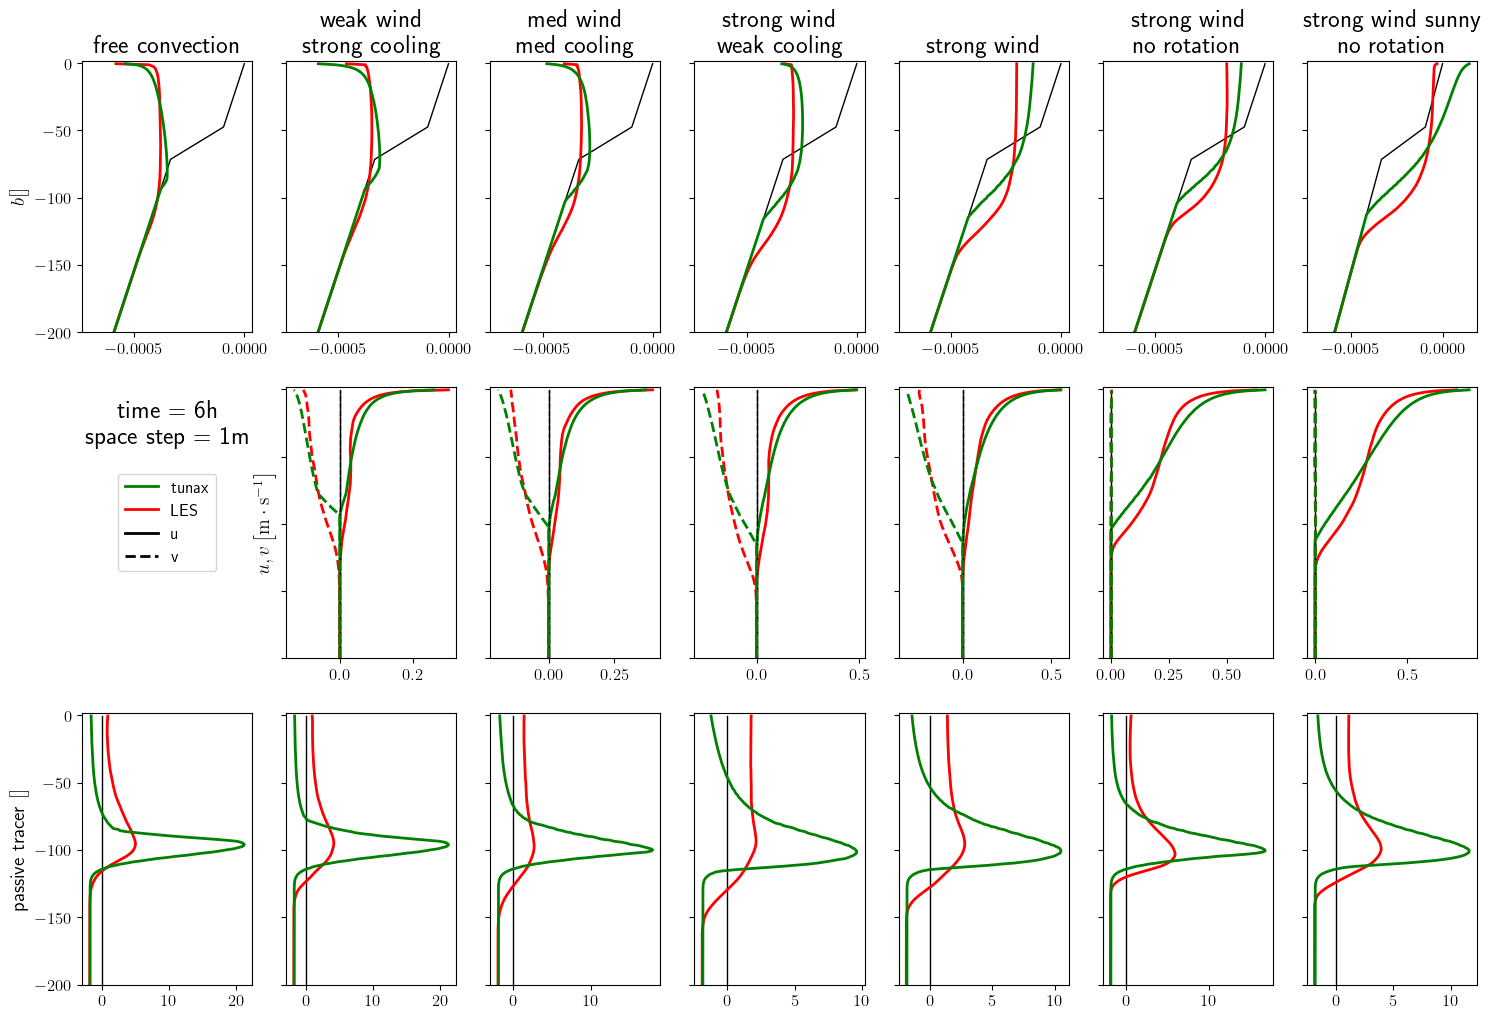

In [5]:
plot_wag(6, 1, -1)